# 1d poissson equation
---
$$
\begin{aligned}
&\frac{d^2 u}{dx^2} = -\sin(x), \ x \in [-\pi, \pi], \\
&u(-\pi) = u(\pi) = 0.
\end{aligned}
$$

Solution:
$$
u(x) = \sin(x).
$$

In [1]:
import flax, flax.nn
from flax import jax_utils, optim
from flax.training import lr_schedule

import jax, jax.nn
from jax import random
import jax.numpy as jnp

import sys
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

In [2]:
class MLP(flax.nn.Module):
	def apply(self, x, layers, activation_fn):
		for l in layers[:-1]:
			x = flax.nn.Dense(x, features = l, 
							 kernel_init = jax.nn.initializers.glorot_uniform(),
							 bias_init = lambda key, shape: jnp.zeros(shape),)
			x = activation_fn(x)
		x = flax.nn.Dense(x, features = layers[-1], 
						 kernel_init = jax.nn.initializers.glorot_uniform(),
						 bias_init = lambda key, shape: jnp.zeros(shape),)
		return x
	
def create_model(key, layers):
	module = MLP.partial(layers = layers, activation_fn = jnp.tanh)
	_, initial_params = module.init_by_shape(key, [(1,)])
	model = flax.nn.Model(module, initial_params)
	return model

layers = [128, 128, 128, 128, 1]
model = create_model(random.PRNGKey(0), layers)

In [3]:
@jax.jit
def mse(pred, true):
	return jnp.sum(jnp.mean(jnp.square(pred - true)))

@jax.jit
def step(optimizer, batch):
	def loss_fn(model):
		
		def scalar_predict(x):
			return jnp.sum(model(x))
        
		def scalar_du_dx(x):
			return jnp.sum(jax.grad(scalar_predict)(x))
        
		@jax.vmap
		def du_dxx(x):
			return jax.grad(scalar_du_dx)(x)

		y_b = model(batch["b"]["x"])
		loss_c = mse(du_dxx(batch["c"]["x"]), -jnp.sin(batch["c"]["x"]))
		loss_br = mse(du_dxx(batch["b"]["x"]), -jnp.sin(batch["b"]["x"]))
		loss_bv = mse(y_b, batch["b"]["y"])
		loss = loss_c + loss_br + loss_bv
		return loss
	
	grad = jax.grad(loss_fn)(optimizer.target)
	optimizer = optimizer.apply_gradient(grad)
	return optimizer

@jax.jit
def evaluate(model, batch):
	def loss_fn(model):
		
		def scalar_predict(x):
			return jnp.sum(model(x))
        
		def scalar_du_dx(x):
			return jnp.sum(jax.grad(scalar_predict)(x))
        
		@jax.vmap
		def du_dxx(x):
			return jax.grad(scalar_du_dx)(x)

		y_b = model(batch["b"]["x"])
		loss_c = mse(du_dxx(batch["c"]["x"]), -jnp.sin(batch["c"]["x"]))
		loss_br = mse(du_dxx(batch["b"]["x"]), -jnp.sin(batch["b"]["x"]))
		loss_bv = mse(y_b, batch["b"]["y"])
		loss = loss_c + loss_br + loss_bv
		return loss, loss_c, loss_br, loss_bv
	return loss_fn(model)

In [4]:
x_c = random.uniform(random.PRNGKey(0), (100, 1), minval = -jnp.pi, maxval = jnp.pi)
x_b = jnp.array([-np.pi, np.pi]).reshape((-1, 1))
f = lambda x: jnp.sin(x)
y_b = f(x_b)
dataset = {"c": {"x": x_c},
		   "b": {"x": x_b, "y": y_b}}

In [5]:
optimizer = flax.optim.Adam(learning_rate = 1e-4).create(model)
for iteration in range(1, 10001):
	optimizer = step(optimizer, dataset)
	if iteration % 1000 == 0:
		names = ("Loss", "c", "br", "bv")
		print("{}, Iteration: {},".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, evaluate(optimizer.target, dataset))]))

2020/07/21, 13:25:21, Iteration: 1000, Loss: 5.0163e-04, c: 4.2532e-04, br: 7.6222e-05, bv: 8.4857e-08
2020/07/21, 13:25:23, Iteration: 2000, Loss: 1.0869e-04, c: 9.6881e-05, br: 1.1804e-05, bv: 3.1045e-09
2020/07/21, 13:25:24, Iteration: 3000, Loss: 4.6634e-05, c: 4.2981e-05, br: 3.6524e-06, bv: 5.8997e-11
2020/07/21, 13:25:25, Iteration: 4000, Loss: 2.0821e-05, c: 1.9364e-05, br: 1.4543e-06, bv: 2.8461e-09
2020/07/21, 13:25:26, Iteration: 5000, Loss: 1.5983e-05, c: 1.1656e-05, br: 1.8387e-08, bv: 4.3087e-06
2020/07/21, 13:25:27, Iteration: 6000, Loss: 6.7409e-06, c: 6.3070e-06, br: 3.7308e-07, bv: 6.0798e-08
2020/07/21, 13:25:28, Iteration: 7000, Loss: 7.0102e-06, c: 4.7545e-06, br: 7.6077e-07, bv: 1.4949e-06
2020/07/21, 13:25:29, Iteration: 8000, Loss: 4.2328e-06, c: 4.1221e-06, br: 1.1065e-07, bv: 1.9846e-11
2020/07/21, 13:25:30, Iteration: 9000, Loss: 3.4458e-06, c: 3.3669e-06, br: 7.7130e-08, bv: 1.7567e-09
2020/07/21, 13:25:31, Iteration: 10000, Loss: 2.7391e-06, c: 2.6769e-06, 

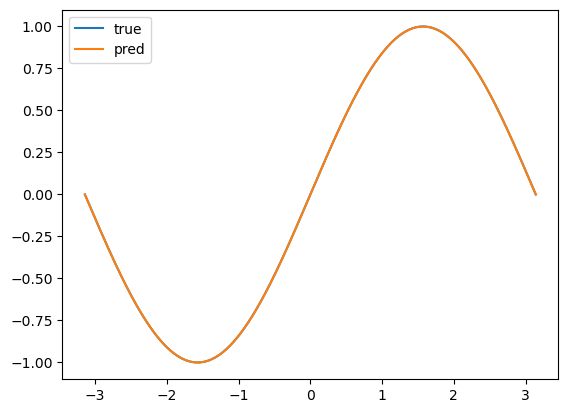

In [9]:
x_test = jnp.linspace(-jnp.pi, jnp.pi, 1000).reshape((-1, 1))
y_test = f(x_test)
y_pred = optimizer.target(x_test)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(x_test, y_test, label = "true")
plt.plot(x_test, y_pred, label = "pred")
plt.legend()
plt.show()